###NOTES TO MYSELF:
+ I'm using 2 inputs here

+ I'm also using bidirectional decoder, and feeding the output from cap_i to the initial state of cap_i+1

+ No image embedding

+ max sequence length is 12

+ using rmsprop optimizer

-- Check validation

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, GRU, Masking, Lambda, Concatenate, Average
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import load_model
import json
import csv

from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint




#Wesam
# SEED = 10
#IMAGE_EMBEDDING_VAL_DIR = '/content/drive/My Drive/Colab_Notebooks/DL_data/validation/'
# IMAGE_EMBEDDING_DIR = '/content/drive/My Drive/Colab_Notebooks/DL_data/one_sample_cnn/'
# filepath = '/content/drive/My Drive/Colab_Notebooks/DL_data/model-ep{epoch:03d}-loss{loss:.3f}.h5'
#CAPTION_FILE_NAME = '/content/drive/My Drive/Colab_Notebooks/DL_data/image_to_caption.csv'


#on my Colab
ALL_CAPTIONS_FILE = '/content/drive/My Drive/Colab_Notebooks/DL_data/all_captions.txt'
COMPLETE_STORIES_FILE = '/content/drive/My Drive/Colab_Notebooks/DL_data/complete_stories_all_splits.json'
IMAGE_EMBEDDING_DIR = '/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/'
GLOVE_EMBEDDING_FILE_NAME = '/content/drive/My Drive/Colab_Notebooks/DL_data/glove.6B.300d.txt'


# #For my GCP:
# ALL_CAPTIONS_FILE = 'all_captions.txt'
# COMPLETE_STORIES_FILE = 'complete_stories_all_splits.json'
# IMAGE_EMBEDDING_DIR = 'CNNFeatureVectors/'
# GLOVE_EMBEDDING_FILE_NAME = 'glove.6B.300d.txt'


#Vinuta
SEED = 10
IMAGE_EMBEDDING_DIM = 2048
#IMAGE_EMBEDDING_DIR = '/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/'
NUM_IMAGE_EMBEDDING_CHUNKS = 10
#GLOVE_EMBEDDING_FILE_NAME = 'glove.6B.300d.txt'
MAX_SEQUENCE_LENGTH = 20
WORD_EMBEDDING_DIM = 300
#CAPTION_FILE_NAME = '/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/image_to_caption.csv'
SENTENCE_EMBEDDING_DIM = 512

Using TensorFlow backend.


In [2]:
#commented for GCP
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#PreProcess Captions / Stories

Either call this function or simply load preprocessed from a file



In [0]:
#to check if story ids are repeated or unique
# story_list = list()
# for key in list(all_captions_dict.keys()):
#   story_list += list(all_captions_dict[key].keys())
# from collections import Counter
# print(len(story_dict))
# d =  Counter(story_dict)
# res = [k for k, v in d.items() if v > 1]
# print(len(res)) ## gave zero .. so story ids are -in fact- unique


#image_embd =  getImageEmbedding(IMAGE_EMBEDDING_DIR)

def get_existing_stories(image_embeddings):
  #load all_captions file
  with open(ALL_CAPTIONS_FILE) as json_file:
    all_captions_dict = json.load(json_file)

  #Create a story dict (no album ids (already checked that story ids are unique))
  story_dict = {}
  for key in list(all_captions_dict.keys()):
    story_dict.update(all_captions_dict[key])


  # Create a Story dict where all images are available in the image_embeddings
  existing_stories = {}
  c=0
  for key in list(story_dict.keys()):
    lists = story_dict[key]
    images = [item[0] for item in lists]
    #captions = ['startseq ' + item[1] + ' endseq' for item in lists]
    captions = [item[1] for item in lists]
    if all(img in list(image_embeddings.keys()) for img in images):
      existing_stories[key] = [images,captions]
      c+=1
      
  print("Number of Stories Found: ")
  print(c)

  # Saving the complete existing story dict in a file
  with open(COMPLETE_STORIES_FILE, 'w') as fp:
      json.dump(existing_stories, fp)
  return existing_stories

#Vocab

In [0]:
 def vocab_fun(existing_stories_dict):
  index_to_word = {}
  word_to_index = {}
  max_seq_len=0
  all_words = {}
  all_words['startseq'] = 1
  all_words['endseq'] = 1
  cap_list = list()
  for story_id, lists in existing_stories_dict.items():
    for cap in lists[1]:
      if(len(cap.split())>max_seq_len):
        max_seq_len = len(cap.split())
      for word in cap.split():
        all_words[word] = 1
  all_vocab=[w for w in all_words]
  index = 1
  for word in all_vocab:
      word_to_index[word] = index
      index_to_word[index] = word
      index += 1



  #MAX_SEQUENCE_LENGTH = #max_seq_len + 1
  return (all_vocab, word_to_index, index_to_word)

In [0]:
# #to deciede sentence length:

# cap_lengths=[]
# for key, lists in existing_stories.items():
#     cap_list=lists[1]
#     for x in cap_list:
#       for c in x.split():
#         cap_lengths.append(len(c))
# print(np.mean(cap_lengths)+ 2 * np.std(cap_lengths))

8.402385321992504


#Preprocess images

In [0]:
def Merge(dict1, dict2): 
    res = {**dict1, **dict2} 
    return res 

def getImageEmbedding(path):
    image_embedding = {}
    for i in range(NUM_IMAGE_EMBEDDING_CHUNKS):
         file_name = path + 'cnn_group'+str(i+1)+'.json'
         with open(file_name) as json_file:
#    with open(file_name) as json_file:
            print(file_name)
            json_data = json.load(json_file)
            json_data = json.loads(json_data)
            image_embedding = Merge(image_embedding, json_data) 
            #image_embedding = json_data 
    return image_embedding

#Load Stories (captions with corresponding Image ids)
##Dict items as follows (per story)
[ [img_id1, img_id2, img_id3, img_id4, img_id5] , [cap1, cap2, cap3, cap4, cap5] ]

In [0]:
def get_existing_stories_from_file():
  with open(COMPLETE_STORIES_FILE, 'r') as fp:
      existing_stories = json.load(fp)
  return existing_stories

#Use Prev to get captions / stories and images and pre_process them

In [7]:
#for training
image_embd =  getImageEmbedding(IMAGE_EMBEDDING_DIR)
print(len(image_embd))


/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group1.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group2.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group3.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group4.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group5.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group6.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group7.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group8.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group9.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group10.json
58197


In [8]:
#get existing_stories (either load from file or using a function , preferably load from file) -- uncomment one of the following 2 lines
existing_stories = get_existing_stories_from_file()
#existing_stories = get_existing_stories(image_embd) #Number of Stories Found: 35565

all_vocab, wordtoix, ixtoword=vocab_fun(existing_stories)
print('Max Seq Len: %d' %MAX_SEQUENCE_LENGTH)
vocab_size = len(all_vocab) + 1
print('Vocabulary Size: %d' % vocab_size) #26571

Max Seq Len: 20
Vocabulary Size: 26572


#Word Embedding Matrix

In [9]:
#get matrix embedding for glove
embeddings_index = {} # empty dictionary
f = open(GLOVE_EMBEDDING_FILE_NAME, encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))


# Get 300-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, WORD_EMBEDDING_DIM))
for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [0]:
# #save embedding matrix:
# np.save('/content/drive/My Drive/Colab_Notebooks/DL_data/embedding_matrix.npy', embedding_matrix) 

In [0]:
# #save dicts needed during inference:
# with open('/content/drive/My Drive/Colab_Notebooks/DL_data/ixtoword.json', 'w') as fp:
#     json.dump(ixtoword, fp)

# with open('/content/drive/My Drive/Colab_Notebooks/DL_data/wordtoix.json', 'w') as fp:
#     json.dump(wordtoix, fp)

#Input and output for the model
###X1, X2, y

In [0]:

import tensorflow as tf
import tensorflow_hub as hub
def all_data(stories_dict, image_embd, wordtoix, max_length, num_of_stories):
  X1, X2, X3, y = list(), list(), list(), list()
  #to generate X1,X2,X3 and y. ////append-> have a list of image embeds , have a list for curr caption, have sentences embed for previous sentences, next word
  #for each story:
  for key, lists in stories_dict.items():
    #break after retreiving num_of_stories
    if num_of_stories <= 0:
      break
    num_of_stories -= 1
    
    img_list=lists[0]
    img_list_embed=[image_embd[img_id] for img_id in img_list]#[imgtoix[img_id] for img_id in img_list]
    # prev_list=lists[1].copy()
    # prev_list.pop()
    # prev_list.insert(0,'')
    in_cap_list = np.zeros((5,max_length))
    out_cap_list = np.zeros((5,max_length))
    for c in range(5):
      #prev_embeddings = [wordtoix[word] for word in prev_list[c].split() if word in wordtoix]
      #prev_list[c] = pad_sequences([prev_embeddings], maxlen=max_length)[0]

      cap=lists[1][c]
      cap_in = 'startseq ' + cap
      cap_out = cap + ' endseq'
      seq_in = [wordtoix[word] for word in cap_in.split() if word in wordtoix]
      seq_in = pad_sequences([seq_in], maxlen=max_length, padding='post', truncating='post')[0]
      seq_out = [wordtoix[word] for word in cap_out.split() if word in wordtoix]
      seq_out = pad_sequences([seq_out], maxlen=max_length, padding='post', truncating='post')[0]
      if len(cap_out.split()) > max_length:
        seq_out[-1]=wordtoix['endseq']
      in_cap_list[c] = np.array(seq_in)
      out_cap_list[c] = np.array(seq_out)
    X1.append(img_list_embed)
    X2.append(in_cap_list)
    #X3.append(prev_list)
    y.append(np.concatenate(out_cap_list).ravel())##out_cap_list

  return (array(X1), array(X2),  array(y))#array(X3),




In [0]:
#X1,X2,y = all_data(existing_stories, image_embd, wordtoix, MAX_SEQUENCE_LENGTH, 2)#35565

# print("X")
# print(X2)
# print("Y")
# print(y)
# print(np.shape(X2))
# print(np.shape(y))

In [0]:
# print("X")
# print(np.shape(y))

X
(2, 100)


In [0]:
#X1,X2,X3,y = all_data(existing_stories, image_embd, wordtoix, MAX_SEQUENCE_LENGTH, 2)

# print("X")
# print(X2)
# print("Y")
# print(y)

X
[[[ 1.  3.  4.  5.  6.  7.  8.  9.  0.  0.  0.]
  [ 1. 10. 11. 12. 13. 14.  9.  0.  0.  0.  0.]
  [ 1. 10. 15. 16. 12. 17. 18.  9.  0.  0.  0.]
  [ 1. 10. 19. 20. 21. 22.  9.  0.  0.  0.  0.]
  [ 1. 23. 10. 11. 20. 24. 25.  9.  0.  0.  0.]]

 [[ 1. 26. 27. 20. 28. 29. 30. 31. 32. 33. 28.]
  [ 1. 28. 34. 20. 35. 36. 31. 14. 37. 38. 39.]
  [ 1. 14. 44. 45. 46. 45. 47. 48. 49. 31. 50.]
  [ 1. 31. 51. 42. 21. 45. 52.  9.  0.  0.  0.]
  [ 1. 53. 54. 55. 56. 57. 36. 58. 31. 50. 59.]]]
Y
[[ 3.  4.  5.  6.  7.  8.  9.  2.  0.  0.  0. 10. 11. 12. 13. 14.  9.  2.
   0.  0.  0.  0. 10. 15. 16. 12. 17. 18.  9.  2.  0.  0.  0. 10. 19. 20.
  21. 22.  9.  2.  0.  0.  0.  0. 23. 10. 11. 20. 24. 25.  9.  2.  0.  0.
   0.]
 [26. 27. 20. 28. 29. 30. 31. 32. 33. 28.  2. 28. 34. 20. 35. 36. 31. 14.
  37. 38. 39.  2. 14. 44. 45. 46. 45. 47. 48. 49. 31. 50.  2. 31. 51. 42.
  21. 45. 52.  9.  2.  0.  0.  0. 53. 54. 55. 56. 57. 36. 58. 31. 50. 59.
   2.]]


In [0]:
# print(np.shape(y))


(5, 55)


#Building Model

In [0]:
# # Things I should try:
# # 1- bidirectional
# # 2- return sequences and merge the two layers
# # 3- must get good results on validation (the model must be generalizable)
# # 4- modify hyper parameters (hidden layers, batch size, learning rate) (with larger batch size we can use larger learning rate)


from keras.regularizers import l2, l1
from keras import backend as K
def sparse_cross_entropy(y_true, y_pred):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred)
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

# def my_sparse_categorical_accuracy(y_true, y_pred):
#   return K.cast(
#         K.equal(K.cast(K.max(y_true), K.floatx()),
#                 K.cast(K.argmax(y_pred, axis=-1), K.floatx())),
#         K.floatx()
#         )

# def custom_sparse_categorical_accuracy(y_true, y_pred):
#     return K.cast(K.equal(K.max(y_true, axis=-1),
#                           K.cast(K.argmax(y_pred, axis=-1), K.floatx())),K.floatx())
def build_model():
###slice = Lambda(lambda x: x[:, i])(input)
    #Image Encoder
    img_input = Input(shape=(5,IMAGE_EMBEDDING_DIM))
    img_encoder_1 = Dropout(0)(img_input)
    img_encoder = GRU(300, recurrent_dropout=0, return_sequences=True , activity_regularizer=l2(0.000))(img_encoder_1) ##might add another layer
    img1_enc = Lambda(lambda x: x[:, 0, :])(img_encoder)
    img2_enc = Lambda(lambda x: x[:, 1, :])(img_encoder)
    img3_enc = Lambda(lambda x: x[:, 2, :])(img_encoder)
    img4_enc = Lambda(lambda x: x[:, 3, :])(img_encoder)
    img5_enc = Lambda(lambda x: x[:, 4, :])(img_encoder)
    #Concatenate()([forward_h, backward_h])

    #Previous Sentences Encoder
    # prev_sents_input = Input(shape=(5,MAX_SEQUENCE_LENGTH))
    # sent1_in = Lambda(lambda x: x[:, 0, :])(prev_sents_input)
    # sent2_in = Lambda(lambda x: x[:, 1, :])(prev_sents_input)
    # sent3_in = Lambda(lambda x: x[:, 2, :])(prev_sents_input)
    # sent4_in = Lambda(lambda x: x[:, 3, :])(prev_sents_input)
    # sent5_in = Lambda(lambda x: x[:, 4, :])(prev_sents_input)
    
    #Embed each:
    Word_Embedder = Embedding(vocab_size, WORD_EMBEDDING_DIM, mask_zero=True, weights=[embedding_matrix], trainable=False)
    # sent1_emb = Word_Embedder(sent1_in)
    # sent2_emb = Word_Embedder(sent2_in)
    # sent3_emb = Word_Embedder(sent3_in)
    # sent4_emb = Word_Embedder(sent4_in)
    # sent5_emb = Word_Embedder(sent5_in)
    
    #define previouse sentences encoder:
    prev_encoder = GRU(100, recurrent_dropout=0, dropout=0.0 , return_sequences=False, activity_regularizer=l2(0.000))

    # #now use the encoder:
    # sent1_enc = prev_encoder(sent1_emb)
    # sent2_enc = prev_encoder(sent2_emb , initial_state = sent1_enc)
    # sent3_enc = prev_encoder(sent3_emb , initial_state = sent2_enc)
    # sent4_enc = prev_encoder(sent4_emb , initial_state = sent3_enc)
    # sent5_enc = prev_encoder(sent5_emb , initial_state = sent4_enc)


    # #now prepare for decoder:
    # hidden_1 = concatenate([sent1_enc,img1_enc])
    # hidden_2 = concatenate([sent2_enc,img2_enc])
    # hidden_3 = concatenate([sent3_enc,img3_enc])
    # hidden_4 = concatenate([sent4_enc,img4_enc])
    # hidden_5 = concatenate([sent5_enc,img5_enc])

    #Decoder:
    decoder = Bidirectional(GRU(300,recurrent_dropout=0, dropout=0.0 ,return_sequences=True, return_state=True ,activity_regularizer=l2(0.000)),  merge_mode='concat' )
    
    #Current captions
    captions_input = Input(shape=(5,MAX_SEQUENCE_LENGTH))

    #split
    cap1_in = Lambda(lambda x: x[:, 0, :])(captions_input)
    cap2_in = Lambda(lambda x: x[:, 1, :])(captions_input)
    cap3_in = Lambda(lambda x: x[:, 2, :])(captions_input)
    cap4_in = Lambda(lambda x: x[:, 3, :])(captions_input)
    cap5_in = Lambda(lambda x: x[:, 4, :])(captions_input)
    
    #Embed each:
    cap1_emb = Word_Embedder(cap1_in)
    cap2_emb = Word_Embedder(cap2_in)
    cap3_emb = Word_Embedder(cap3_in)
    cap4_emb = Word_Embedder(cap4_in)
    cap5_emb = Word_Embedder(cap5_in)

    # Concat
    #hidden_1 = concatenate([sent1_enc,img1_enc])



    #Decode
    cap1_dec, prev_1_f , prev_1_b = decoder(cap1_emb, initial_state = [img1_enc,img1_enc] )

    fprev_1 = Average()([prev_1_f,img2_enc])
    bprev_1 = Average()([prev_1_b,img2_enc])
    hidden_2 = [fprev_1,bprev_1]
    cap2_dec, prev_2_f, prev_2_b= decoder(cap2_emb , initial_state = hidden_2)

    fprev_2 = Average()([prev_2_f,img3_enc])
    bprev_2 = Average()([prev_2_b,img3_enc])
    hidden_3 = [fprev_2,bprev_2]
    cap3_dec, prev_3_f, prev_3_b = decoder(cap3_emb , initial_state = hidden_3)

    fprev_3 = Average()([prev_3_f,img4_enc])
    bprev_3 = Average()([prev_3_b,img4_enc])
    hidden_4 = [fprev_3,bprev_3]
    cap4_dec, prev_4_f, prev_4_b = decoder(cap4_emb , initial_state = hidden_4)

    fprev_4 = Average()([prev_4_f,img5_enc])
    bprev_4 = Average()([prev_4_b,img5_enc])
    hidden_5 = [fprev_4,bprev_4]
    cap5_dec, prev_5_f, prev_5_b = decoder(cap5_emb , initial_state = hidden_5)

    decoder_out = concatenate([cap1_dec, cap2_dec, cap3_dec, cap4_dec, cap5_dec], axis=-2)

    decoder_dense = Dense(200, activation=None, kernel_regularizer=l2(0.000))(decoder_out)
    outputs = Dense(vocab_size, activation='linear')(decoder_dense) ##was softmax /// used linear because it's recommended with the custom loss: https://github.com/tensorflow/tensorflow/issues/17150
    model = Model(inputs=[img_input, captions_input], outputs=outputs)

    model.summary()
    decoder_target = tf.placeholder(dtype='int32', shape=(None, None))
    model.compile(loss=sparse_cross_entropy, optimizer='rmsprop', target_tensors=[decoder_target])#'adam') #, target_tensors=[decoder_target]
#'sparse_categorical_crossentropy'
#tf.keras.losses.SparseCategoricalCrossentropy()
# metrics=[custom_sparse_categorical_accuracy]
    return model

#Training

In [12]:
model=build_model()










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 2048)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 5, 20)        0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 5, 2048)      0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 20)           0           input_2[0][0]          

#Or load saved model

In [0]:
#model = load_model('/content/drive/My Drive/Colab_Notebooks/DL_data/models/final_model_basic_100_stories_checkpoint-ep033-loss3.835.h5')

#Prep for training

In [0]:
X1,X2,y = all_data(existing_stories, image_embd, wordtoix, MAX_SEQUENCE_LENGTH, 1000)#35565
#for GCP
# filepath_checkpoint = "final_model_all_stories-ep{epoch:03d}-loss{loss:.3f}.h5"
# filepath_model = 'final_model_all_stories_finale.h5'

# # #for Colab
# filepath_checkpoint = "/content/drive/My Drive/Colab_Notebooks/DL_data/models/Suggested_10_-ep{epoch:03d}-loss{loss:.3f}.h5"
# filepath_model = '/content/drive/My Drive/Colab_Notebooks/DL_data/models/Suggested_10_epoch1.h5'




#Training

In [14]:

#checkpoint = ModelCheckpoint(filepath_checkpoint, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit([X1,X2], y, epochs=20, verbose=2, batch_size=32, validation_split=0.1, shuffle=True, workers=10, use_multiprocessing=True) #callbacks=[checkpoint]



Train on 900 samples, validate on 100 samples
Epoch 1/20
 - 18s - loss: 4.2788 - val_loss: 2.8136
Epoch 2/20
 - 10s - loss: 2.7624 - val_loss: 2.1815
Epoch 3/20
 - 11s - loss: 2.0458 - val_loss: 1.7114
Epoch 4/20
 - 11s - loss: 1.5326 - val_loss: 1.3702
Epoch 5/20
 - 11s - loss: 1.1564 - val_loss: 1.1449
Epoch 6/20
 - 11s - loss: 0.8693 - val_loss: 0.9801
Epoch 7/20
 - 10s - loss: 0.6613 - val_loss: 0.8878
Epoch 8/20
 - 11s - loss: 0.5026 - val_loss: 0.8357
Epoch 9/20
 - 11s - loss: 0.3785 - val_loss: 0.7880
Epoch 10/20
 - 11s - loss: 0.2795 - val_loss: 0.7818
Epoch 11/20
 - 10s - loss: 0.2011 - val_loss: 0.7657
Epoch 12/20
 - 11s - loss: 0.1397 - val_loss: 0.7970
Epoch 13/20
 - 11s - loss: 0.0950 - val_loss: 0.7773
Epoch 14/20
 - 11s - loss: 0.0648 - val_loss: 0.7837
Epoch 15/20
 - 11s - loss: 0.0443 - val_loss: 0.7779
Epoch 16/20
 - 11s - loss: 0.0308 - val_loss: 0.8006
Epoch 17/20
 - 11s - loss: 0.0227 - val_loss: 0.8036
Epoch 18/20
 - 11s - loss: 0.0168 - val_loss: 0.8143
Epoch 1

#Plot loss curve

dict_keys(['val_loss', 'loss'])


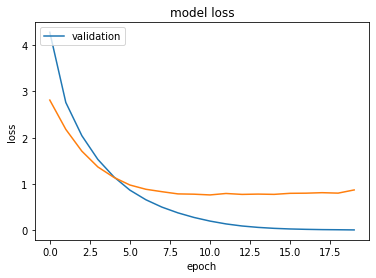

In [16]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.legend(['validation'], loc='upper left')
plt.show()

In [34]:
print(y[10])
x1 = X1[10]
x2 = X2[10].copy()
tmp=''
for w in y[10]:
  if w in ixtoword:
    if w == 'endseq': continue
    tmp += ' ' + ixtoword[w]
print(tmp)

yhat = model.predict([x1[np.newaxis,...],x2[np.newaxis,...]], verbose=0)
print("yhat")
print(np.shape(yhat))

[ 31. 221. 222.   7.  31. 223. 224.   9.   2.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.  31. 225.  72. 226. 227.   9.   2.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  62. 228.
   7. 229.   9.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  62. 230.  16.  62. 231. 232.   5.  31. 233. 234.
 137.   2.   0.   0.   0.   0.   0.   0.   0.   0. 100.  80.  68.  93.
  62. 152.   9.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
 the fish pond was the main attraction . endseq the flowers were also pretty . endseq this bug was interesting . endseq this women made this kid go to the plant garden , endseq time for fun on this ride . endseq
yhat
(1, 100, 26572)


In [35]:
yhat_s = yhat[0,:,:]
print(yhat_s.shape)
print(np.argmax(yhat_s, axis=-1))
tmp=''
for w in np.argmax(yhat_s, axis=-1):
  if w in ixtoword:
    if w == 'endseq': continue
    tmp += ' ' + ixtoword[w]
print(tmp)

(100, 26572)
[ 31 221 222   7  31 223 224   9   2   0   0   0   0   0   0   0   0   0
   0   0  31 225  72 226 227   9   2   0   0   0   0   0   0   0   0   0
   0   0   0   0  62 228   7 229   9   2   0   0   0   0   0   0   0   0
   0   0   0   0   0   0  62 230  16  62 231 232   5  31 233 234 137   2
   0   0   0   0   0   0   0   0 100  80  68  93  62 152   9   2   0   0
   0   0   0   0   0   0   0   0   0   0]
 the fish pond was the main attraction . endseq the flowers were also pretty . endseq this bug was interesting . endseq this women made this kid go to the plant garden , endseq time for fun on this ride . endseq


#TRY validation:

In [49]:
import numpy as np
from scipy.ndimage.interpolation import shift
#X1: 1x5x2048 --images
#X2: 1x5x20  --captions
index_v = 15
x1_v = X1[index_v]
x2_v = X2[index_v].copy()
x2_v_in = np.zeros_like(x2_v)
x2_v_out = np.zeros_like(x2_v)
for i in range(5):
  x2_v_in[i][0] = wordtoix['startseq']
  for j in range(MAX_SEQUENCE_LENGTH): 
    yhat = model.predict([x1_v[np.newaxis,...],x2_v_in[np.newaxis,...]], verbose=0)
    yhat_s = yhat[0,:,:]
    cur = np.argmax(yhat_s[j])
    #if ixtoword[cur] == 'endseq': break
    if j+1<MAX_SEQUENCE_LENGTH:
      x2_v_in[i][j+1] = cur
    x2_v_out[i][j] = cur




print(x2_v_in)
print(x2_v_out)

caps=''
here = np.concatenate(x2_v_out).ravel()
for w in here:
  if w in ixtoword:
    if ixtoword[w] == 'startseq' or ixtoword[w] =='endseq': continue
    caps += " " + ixtoword[w]
print("Captions:")
print(caps)

print('Original X2')
print(X2[index_v])
or_f = np.concatenate(X2[index_v]).ravel()

o=''
for w in or_f:
  if w in ixtoword:
    if ixtoword[w] == 'startseq' or ixtoword[w] =='endseq': continue
    o += " "+ ixtoword[w]
print("Original") #X3[1]
print(o)

[[  1.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.
    2.   2.   2.   2.   2.   2.]
 [  1. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863.
  863. 863. 863. 863. 863.   0.]
 [  1. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863.
  863. 863. 863. 863. 863.   0.]
 [  1. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863.
  863. 863. 863. 863. 863.   0.]
 [  1. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863.
  863. 863. 863. 863. 863.   0.]]
[[  2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.
    2.   2.   2.   2.   2.   2.]
 [863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863.
  863. 863. 863. 863.   0.   2.]
 [863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863.
  863. 863. 863. 863.   0.   2.]
 [863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 863.
  863. 863. 863. 863.   0.   2.]
 [863. 863. 863. 863. 863. 863. 863. 863. 863. 863. 86

In [0]:
#save weights:
model.save_weights('/content/drive/My Drive/Colab_Notebooks/DL_data/models/final_model_all_weights_sure.h5')
model.save('/content/drive/My Drive/Colab_Notebooks/DL_data/models/final_model_basic_all_stories_finale_pad_sure.h5')
##model2.load_weights()

In [0]:
# filepath_model_load = '/content/drive/My Drive/Colab_Notebooks/DL_data/models/final_model_basic_100_stories_finale.h5'
#sen3_layer
# model_loaded = load_model(filepath_model_load, custom_objects={'sparse_cross_entropy': tf.nn.softmax_cross_entropy_with_logits})
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

for name, weight in zip(names, weights):
    print(name, weight)